<h1 align="center">Volatility Prediction</h1>

## Introduction

In the era of chaos and confusion amidst a pandemic, the uncertainty surrounding the stock market has never been higher. VIX, also known as the 'fear index', had hit record high recently.

Volatility is possibly the most popular risk indicator. It represents how large an asset's prices swing around the mean price — it is a statistical measure of its dispersion of returns.

Volatility is a critical metric in the value-at-risk calculation and is a one of the key variables in options pricing and asset allocation models. Predicting tomorrow's volatility is key to the future investment.

In this notebook, we will demonstrate how a machine learning-based model may improve volatility prediction accuracy. In order to compare the predicted performance, we will look at different machine learning (ML) algorithms, including deep learning, neural networks, and support vector regression.

[Link to dataset](https://drive.google.com/drive/folders/1ZhT12d863JiA7fBbPS1SSZAW9gaLsdZP?usp=share_link)

**Concept of Volatility**

The volatility $\sigma$ of a stock is a measure of our uncertainty about the returns provided by the stock. It can be defined as the standard deviation of the return provided by the stock.

Volatility can be measured in several ways. One of the most notable way is to measure *realized volatility*, which is the standard deviation of daily stock return. Intuitively, this quantity represents how large an asset's returns swing around their mean.

**Formula of Realized Volatility**:
$$\hat{\sigma}=\sqrt{\frac{1}{N-1}\sum^{N}_{n=1}(r_{n}-\mu)^{2}}$$
where $r_{n}$ and $\mu$ are the return of the $n^{th}$ day and mean of return, respectively, and N is number of observations.

## Setup

**Modules**

In [3]:
from scipy.stats import norm
import scipy.optimize as opt
from datetime import datetime
import time
from arch import arch_model
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import pandas as pd
from pandas.tseries.offsets import BusinessDay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from warnings import filterwarnings
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV
import random
import torch
import torch.nn as nn
from sklearn.neural_network import MLPRegressor
import glob
import os
filterwarnings('ignore')
# plt.style.use('fivethirtyeight')
# plt.style.use('dark_background')

**Utility functions**

In [4]:
def convertToDate(x: str):
    if isinstance(x, str):
        return datetime.strptime(x, '%d/%m/%Y')
    return x

def toFloat(x: str):
    if isinstance(x, str):
        return float("".join(x.split(',')))
    return x

def toInt(x: str):
    if isinstance(x, str):
        return int("".join(x.split(',')))
    return x

def preprocess(stock: str, data_dict: dict):
    assert stock in data_dict, "This stock is not in the data folder"
    df = data_dict[stock]
    df = df.drop_duplicates().reset_index(drop=True)
    df.date = df.date.apply(convertToDate)
    df = df.sort_values(by='date').reset_index(drop=True)
    for column in ['close', 'high', 'open', 'low']:
        df[column] = df[column].apply(toFloat) 
    for column in ['value', 'volume']:
        df[column] = df[column].apply(toInt)
    df['return'] = df.close.pct_change().apply(lambda x: x*100)
    df['return'][0] = 0
    df['realized_vol'] = df['return'].rolling(5).std()
    df['future_rv'] = df['realized_vol'].shift(-1)
    return df

**Read data**

Now we are going to read our data (originally in JSON) to Pandas dataframes. We make sure that Pandas do not convert our dates automatically since its mechanism might mess up the format of the dates.

In [5]:
df = pd.read_json('./data/VNINDEX.json', convert_dates=False)
# df = pd.read_json('.//VN30INDEX.json', convert_dates=False)

Since we will need data from multiple stocks later, let's read them all then preprocess them.

In [6]:
path = './data/'
all_files = os.listdir(path)

data_dict = {}

for filename in all_files:
    temp = pd.read_json(path+filename, convert_dates=False)
    data_dict[filename[:-5]] = temp
   
# Preprocessing
for stock in data_dict:
    data_dict[stock] = preprocess(stock, data_dict)

## Preprocessing

### Good ol' NaN and Duplicates

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   close   2400 non-null   object
 1   date    2400 non-null   object
 2   high    2400 non-null   object
 3   low     2400 non-null   object
 4   open    2400 non-null   object
 5   value   2400 non-null   object
 6   volume  2400 non-null   object
dtypes: object(7)
memory usage: 131.4+ KB


Good, we do not record any null values in any columns

In [8]:
df[df.date.isin(df.date[df.date.duplicated()])].sort_values("date")

,close,date,high,low,open,value,volume
1865,622.10,09/07/2015,626.38,613.34,616.20,"2,317,564,000,000","128,294,490"
1845,622.10,09/07/2015,626.38,613.34,616.20,"2,317,564,000,000","128,294,490"
1864,627.28,10/07/2015,630.79,624.70,627.56,"2,423,692,000,000","149,777,420"
1844,627.28,10/07/2015,630.79,624.70,627.56,"2,423,692,000,000","149,777,420"
1863,634.06,13/07/2015,637.07,627.69,631.56,"2,207,462,000,000","129,540,480"
1843,634.06,13/07/2015,637.07,627.69,631.56,"2,207,462,000,000","129,540,480"
963,901.80,14/01/2019,903.83,897.18,903.83,"1,929,601,000,000","102,708,100"
983,901.80,14/01/2019,903.83,897.18,903.83,"1,929,601,000,000","102,708,100"
1862,638.69,14/07/2015,640.43,628.43,635.55,"2,721,643,000,000","148,057,910"
1842,638.69,14/07/2015,640.43,628.43,635.55,"2,721,643,000,000","148,057,910"


We do have some duplicated records. Let's drop them.

In [9]:
df = df.drop_duplicates().reset_index().drop(labels='index', axis=1)
df

,close,date,high,low,open,value,volume
0,960.65,21/11/2022,973.19,956.77,971.58,"7,410,514,437,050","522,703,800"
1,969.33,18/11/2022,971.77,939.73,967.18,"11,559,773,695,840","839,360,900"
2,969.26,17/11/2022,972.88,950.90,952.91,"9,178,099,468,260","589,534,338"
3,942.90,16/11/2022,945.42,873.78,876.00,"12,296,091,455,480","934,066,100"
4,911.90,15/11/2022,929.06,900.17,926.08,"9,523,822,985,480","682,787,797"
...,...,...,...,...,...,...,...
2385,483.99,17/04/2013,483.99,476.53,482.17,"455,182,758,000","28,380,260"
2386,478.07,16/04/2013,479.97,466.56,475.07,"811,156,808,000","46,214,530"
2387,480.02,15/04/2013,491.77,478.80,491.65,"852,268,734,000","51,237,740"
2388,494.27,12/04/2013,505.90,490.82,505.37,"858,747,442,000","50,661,340"


Looks like we're good to move on

### Date related

Now, we gotta ***manually*** (no, we should not trust Pandas) convert our *date* column, which is originally of **str** type to proper **datetime.date** type.

In [10]:
df.date = df.date.apply(convertToDate)

Then we sort our table by *date*, so that the latest record is on top.

In [11]:
df = df.sort_values(by='date').reset_index().drop(labels=['index'], axis=1)
df

,close,date,high,low,open,value,volume
0,504.07,2013-04-11,504.51,497.16,501.39,"900,375,861,000","46,971,210"
1,494.27,2013-04-12,505.90,490.82,505.37,"858,747,442,000","50,661,340"
2,480.02,2013-04-15,491.77,478.80,491.65,"852,268,734,000","51,237,740"
3,478.07,2013-04-16,479.97,466.56,475.07,"811,156,808,000","46,214,530"
4,483.99,2013-04-17,483.99,476.53,482.17,"455,182,758,000","28,380,260"
...,...,...,...,...,...,...,...
2385,911.90,2022-11-15,929.06,900.17,926.08,"9,523,822,985,480","682,787,797"
2386,942.90,2022-11-16,945.42,873.78,876.00,"12,296,091,455,480","934,066,100"
2387,969.26,2022-11-17,972.88,950.90,952.91,"9,178,099,468,260","589,534,338"
2388,969.33,2022-11-18,971.77,939.73,967.18,"11,559,773,695,840","839,360,900"


### Columns data type related issues
Here we make sure of **two** things:
- *open*, *low*, *high* and *close* are all of **float** type
- *value* and *volume* are of **int** type

In [12]:
for column in ['close', 'high', 'open', 'low']:
    df[column] = df[column].apply(toFloat)
    
for column in ['value', 'volume']:
    df[column] = df[column].apply(toInt)

In [13]:
df

,close,date,high,low,open,value,volume
0,504.07,2013-04-11,504.51,497.16,501.39,900375861000,46971210
1,494.27,2013-04-12,505.90,490.82,505.37,858747442000,50661340
2,480.02,2013-04-15,491.77,478.80,491.65,852268734000,51237740
3,478.07,2013-04-16,479.97,466.56,475.07,811156808000,46214530
4,483.99,2013-04-17,483.99,476.53,482.17,455182758000,28380260
...,...,...,...,...,...,...,...
2385,911.90,2022-11-15,929.06,900.17,926.08,9523822985480,682787797
2386,942.90,2022-11-16,945.42,873.78,876.00,12296091455480,934066100
2387,969.26,2022-11-17,972.88,950.90,952.91,9178099468260,589534338
2388,969.33,2022-11-18,971.77,939.73,967.18,11559773695840,839360900


Looks like we're good to move on. Let's plot the *close* time-series just for fun

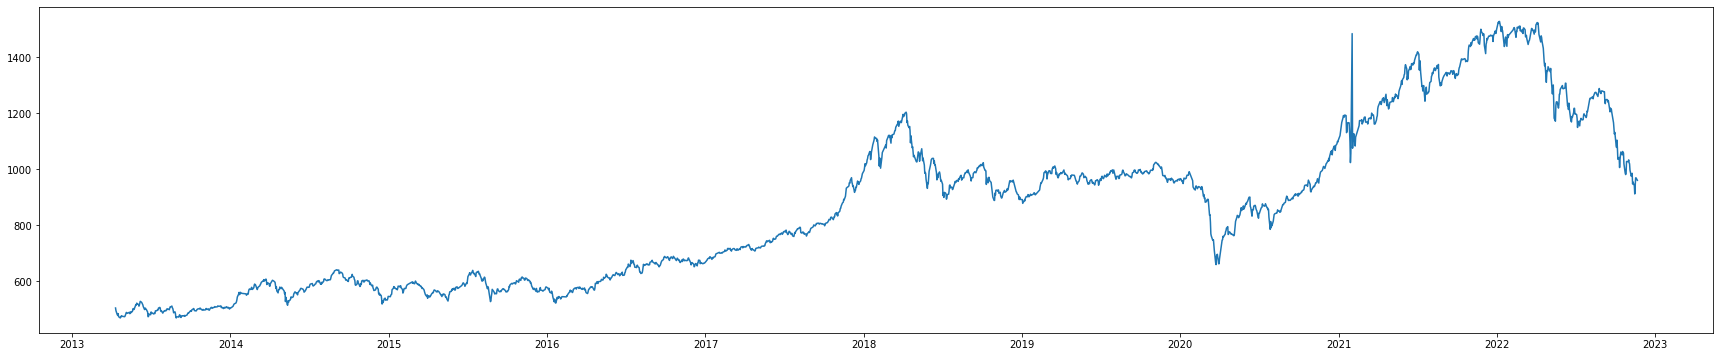

In [14]:
plt.figure(figsize=(30,6))
plt.plot(df['date'], (df['close']))

Hmm, what is that upstick early into 2021? Seems like we have another issue of outliers. Let's figure it out.

### Outliers

First, let's write a function to plot the gaining of every trading day compared to the previous trading day

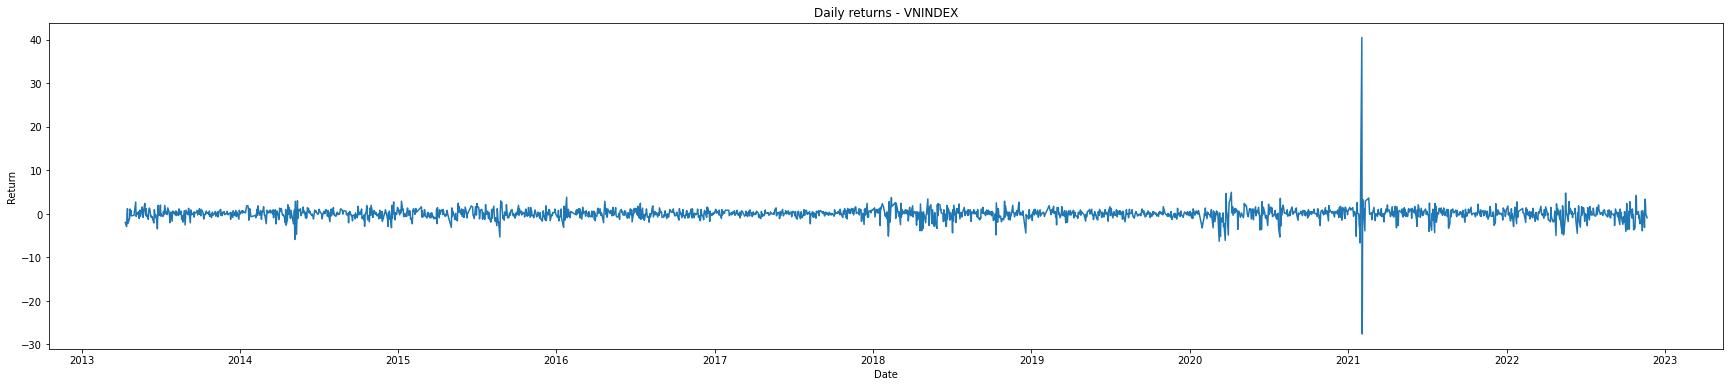

In [15]:
gain = df.close.pct_change().apply(lambda x: x*100)
plt.figure(figsize=(30, 6))
plt.plot(df['date'], gain)
plt.title('Daily returns - VNINDEX')
plt.ylabel('Return')
plt.xlabel('Date')
plt.show()

Seems like we need to zoom into that period

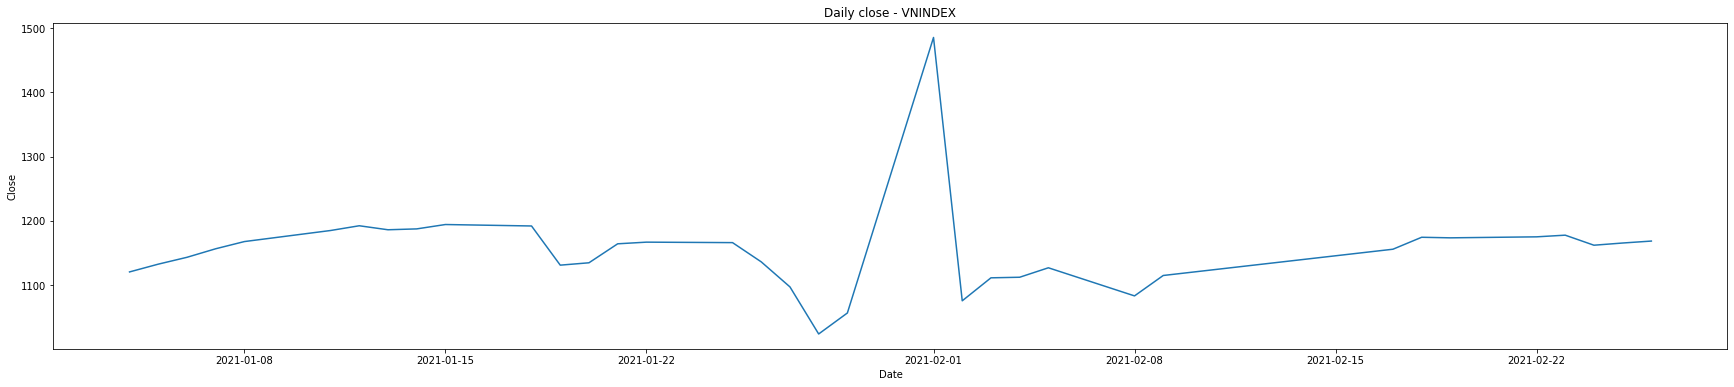

In [16]:
df_draw = df.loc[(df.date > datetime(2021,1,1)) & (df.date < datetime(2021,3,1))]
plt.figure(figsize=(30, 6))
plt.plot(df_draw['date'], df_draw['close'])
plt.title('Daily close - VNINDEX')
plt.ylabel('Close')
plt.xlabel('Date')
plt.show()

Good, seems like we don't have any exorbitant record except that particular day in early 2021 

In [17]:
gain[gain > 30]

1940    40.561797
Name: close, dtype: float64

Got it. Got the index.

In [18]:
idx = gain[gain > 30].index[0]

In [19]:
df.loc[idx]

close                 1485.19
date      2021-02-01 00:00:00
high                  1487.68
low                    1471.3
open                  1477.85
value          24687447720000
volume               81095140
Name: 1940, dtype: object

In [20]:
value = df.loc[idx].close
value

1485.19

In [21]:
df[df.close == value]

,close,date,high,low,open,value,volume
1940,1485.19,2021-02-01,1487.68,1471.3,1477.85,24687447720000,81095140
2147,1485.19,2021-12-01,1487.68,1471.3,1477.85,24687447720000,810951400


Woah. Looks like some problems happened during scraping that created a copy of 2021-Dec-01 to 2021-Feb-01. Let's just google the actual data for that day.

Update: After some googling we have acquired the accurate data about that trading day. We will update in the next code cell.

In [22]:
fixlist = [1035.51, 1056.61, 1074.52, 1035.51, 12287975000000, 588446500]
for count, column in enumerate(['close', 'open', 'high', 'low', 'value', 'volume']):
    df[column][idx] = fixlist[count]
del fixlist
df.loc[idx]

close                 1035.51
date      2021-02-01 00:00:00
high                  1074.52
low                   1035.51
open                  1056.61
value          12287975000000
volume              588446500
Name: 1940, dtype: object

### Calculate return of every trading day
Add columns *return* and *realized volatility*, and *future_rv* (the next day's realized_vol) to the dataframe

In [23]:
df['return'] = df.close.pct_change().apply(lambda x: x*100)
df['return'][0] = 0
df['realized_vol'] = df['return'].rolling(5).std()
df['future_rv'] = df['realized_vol'].shift(-1)

# Show the dataframe
df

,close,date,high,low,open,value,volume,return,realized_vol,future_rv
0,504.07,2013-04-11,504.51,497.16,501.39,900375861000,46971210,0.000000,NaN,NaN
1,494.27,2013-04-12,505.90,490.82,505.37,858747442000,50661340,-1.944174,NaN,NaN
2,480.02,2013-04-15,491.77,478.80,491.65,852268734000,51237740,-2.883040,NaN,NaN
3,478.07,2013-04-16,479.97,466.56,475.07,811156808000,46214530,-0.406233,NaN,1.627725
4,483.99,2013-04-17,483.99,476.53,482.17,455182758000,28380260,1.238312,1.627725,1.658865
...,...,...,...,...,...,...,...,...,...,...
2385,911.90,2022-11-15,929.06,900.17,926.08,9523822985480,682787797,-3.096574,2.063098,2.970426
2386,942.90,2022-11-16,945.42,873.78,876.00,12296091455480,934066100,3.399496,2.970426,2.754323
2387,969.26,2022-11-17,972.88,950.90,952.91,9178099468260,589534338,2.795631,2.754323,2.756144
2388,969.33,2022-11-18,971.77,939.73,967.18,11559773695840,839360900,0.007222,2.756144,2.682616


In [24]:
df_draw = df.loc[(df.date >= datetime(2022,11,1))]

Once again, let's plot our past *realized volatility* for fun

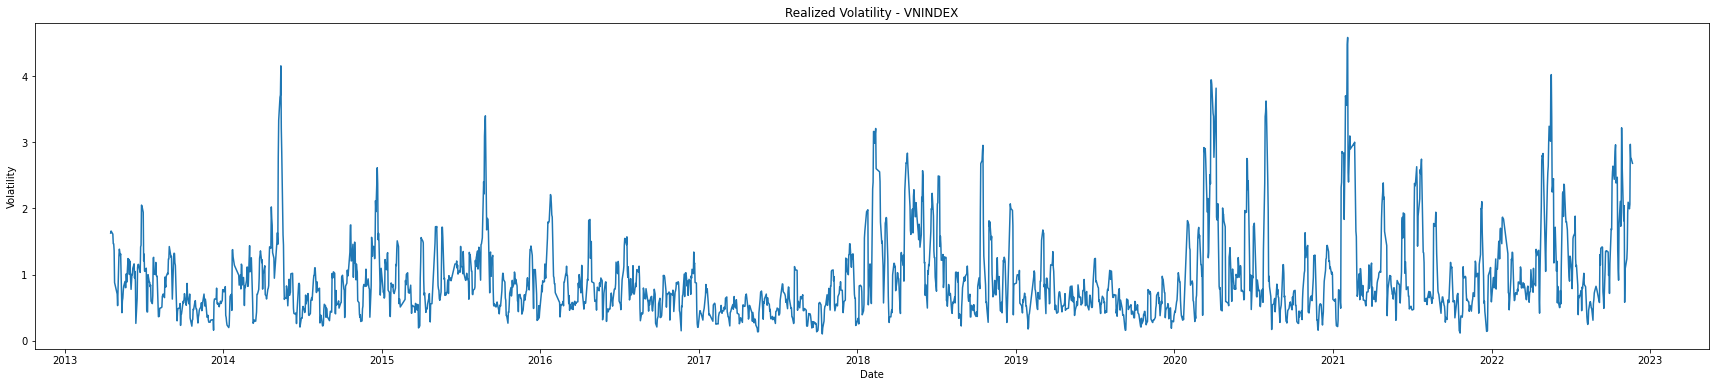

In [25]:
plt.figure(figsize=(30, 6))
plt.plot(df['date'],df['realized_vol'])
plt.title('Realized Volatility - VNINDEX')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

## Volatility Forecasting

Before we do anything, let's split our data into training and testing data. Let's try to predict the volatility for the last 251 day using all the prior data we have. Feel free to change the number of prediction (testing) length.

In [26]:
n_test = 251
test_start = len(df)-n_test
test_label = df['realized_vol'][-n_test:] / 100

### General information

1. Models we're going to use

> **Classical**: ARCH, GARCH

> **ML-based**: SVR-GARCH, MLP

2. Training and inference

> Model by model, respectively

3. Evaluation of models

> **Metrics**: RMSE (label would be *realized volatility* that we have calculated), Correlation to VIX

> In combination with hypothesis testing

### Forecasting

#### I. Autoregressive Conditional Heteroskedasticity (ARCH) - Eagle, 1982

**Form of *ARCH* - Equation 1**:

>$\sigma_{t}^{2}=\omega+\sum^{p}_{k=1}\alpha_{k}(r_{t-k})^2$

Accordingly, the return is modeled as follow:
>$r_{t}=\sigma_{t}\epsilon_{t}$

In which, $\epsilon_{t}$ is assumed to follow a certain normal distribution. Furthermore, the following conditions should be satisfied (so that $\sigma_{t}^{2}$ is strictly positive):
- $\omega>0$
- $\alpha_{k}>=0$

**Some properties of ARCH**:
1. ARCH is univariate and nonlinear
2. ARCH allows the conditional variance to depend on the data, hence it is capable of modeling volatility clustering. Volatility clustering refers to the observation that large changes in asset return tend to be followed by large changes and small changes tend to be followed by small changes.

We can observe the volatility clustering as follows:

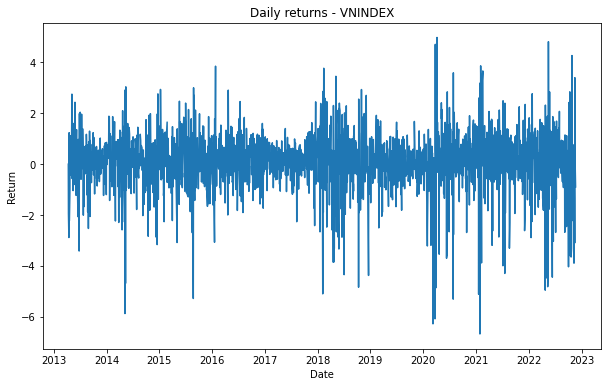

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['return'])
plt.title('Daily returns - VNINDEX')
plt.ylabel('Return')
plt.xlabel('Date')
plt.show()

**Some drawbacks of ARCH**:
- It does not reflect the inherent differences between winning and losing shocks
- Big, impactful restrictions on parameters
- Slow adjustments

**Training and Inference using ARCH**

We don't need to build the model from scratch since there is already a library for it. We will determine the best-performing hyperparameter $p$ in Equation 1 by using Bayes Information Criterion (BIC).

***Overview of Bayes Information Criterion***:
1. BIC is a criterion for model selection among a finite set of models; models with lower BIC are generally preferred.
2. When fitting models, it is possible to increase the likelihood by adding parameters, but doing so may result in overfitting. BIC attempts to resolve this problem by introducing a penalty term for the number of parameters in the model.
3. BIC is formally defined as:
> $\mathrm{BIC}=k\mathrm{ln}(n)-2\mathrm{ln}(\hat{L})$

where:
- $\hat{L}$ denotes the maximized value of the likelihood function of the model M, i.e. $\hat{L}=p(x\hspace{1pt}|\hspace{1pt} \hat{\theta}, M)$ where $\hat{\theta}$ are the parameter values that maximize the likelihood function
- $x$ denotes the observed data
- $n$ denotes the sample size
- $k$ denotes the number of parameters estimated by the model. For example, in multiple linear regression, the estimated parameters are the intercept, the $q$ slope parameters, and the constant variance of the errors; thus, $k=q+2$.

Training:

In [28]:
def ARCH_modelSelect(ret):
    bic_arch = []
    best_param = -1
    for p in range(1, 5):
        arch = arch_model(ret, mean='zero', vol='ARCH', p=p).fit(disp='off')
        bic_arch.append(arch.bic)
        if arch.bic == np.min(bic_arch):
            best_param = p
    return best_param, arch_model(ret, mean='zero', vol='ARCH', p=best_param).fit(disp='off')

best_hyperparam, arch = ARCH_modelSelect(ret=df['return'])
print(arch.summary())
print(f"The best p is {best_hyperparam}")

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3497.43
Distribution:                  Normal   AIC:                           7002.86
Method:            Maximum Likelihood   BIC:                           7025.98
                                        No. Observations:                 2390
Date:                Fri, Feb 10 2023   Df Residuals:                     2390
Time:                        13:21:25   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.6311  6.744e-02      9.358  8.097e-21   [  0.49

Testing and calculating RMSE:

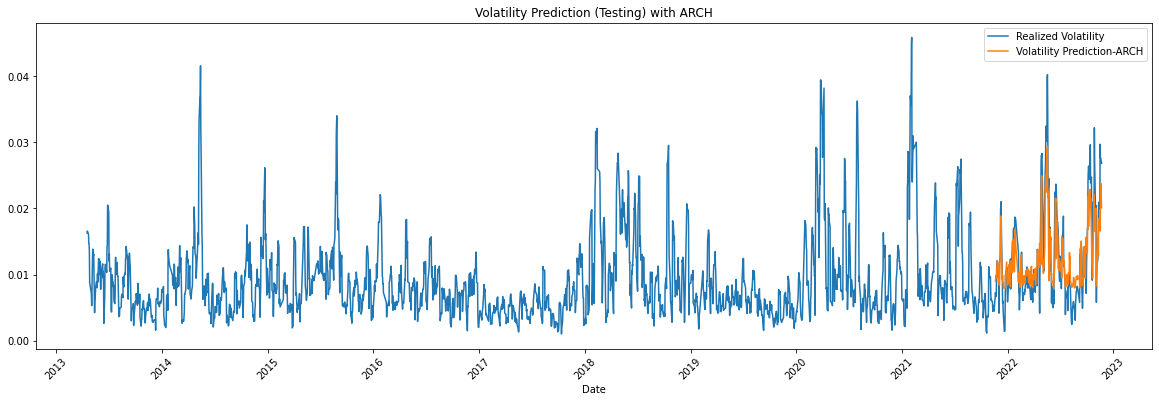

The RMSE value of ARCH model is 0.0132


In [29]:
test_arch = arch.forecast(start=test_start-1)
plt.figure(figsize=(20, 6))

# Build predicted dataframe
pred_date = df['date'][test_start:]
pred_vola = test_arch.variance['h.1'].values[test_start-1:-1]
pred_dict = {
    'date': pred_date,
    'vola': pred_vola
}
pred = pd.DataFrame(pred_dict)

# Plot
plt.plot(df['date'], df['realized_vol']/100, label='Realized Volatility')
plt.plot(pred['date'], np.sqrt(pred['vola']) / 100, label='Volatility Prediction-ARCH', alpha=1)
# plt.plot(df['date'], np.sqrt(test_arch.variance) / 100, label='Volatility Prediction-ARCH', alpha=1)
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Volatility Prediction (Testing) with ARCH', fontsize=12)
plt.legend()
plt.show()

rmse_arch = np.sqrt(mse(test_label / 100,
                        np.sqrt(pred.vola) / 100))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

***The Classic Prophecy (trial)***:

The forecast function:

In [30]:
def classic_forecast(df: pd.DataFrame, horizon: int, model, plotres=False):
    # Forecast
    forecast_arch = model.forecast(horizon=horizon)
    
    # Build forecast dataframe
    latest_date = df['date'].iloc[-1]
    forecast_date = [latest_date + i*BusinessDay() for i in range(1, horizon+1)] # Python list to store the next n_forecast trading dates
#     forecast_vola = forecast_arch.variance.iloc[-1].values
    forecast_vola = forecast_arch.variance.values[-1, :]
    
    forecast_dict = {
        'date': forecast_date,
        'vola': forecast_vola,
    }
    forecast = pd.DataFrame(forecast_dict)
    
    # Draw
    if plotres:
        plt.figure(figsize=(20, 6))
        plt.plot(df['date'].iloc[-50:], df['realized_vol'][-50:] / 100, label='Realized Volatility')
        plt.plot(forecast['date'], forecast['vola'] / 100, label='Volatility Prediction-ARCH')
        plt.title('Volatility Forecasting with ARCH', fontsize=12)
        plt.legend()
        plt.show()
    
    return forecast_vola

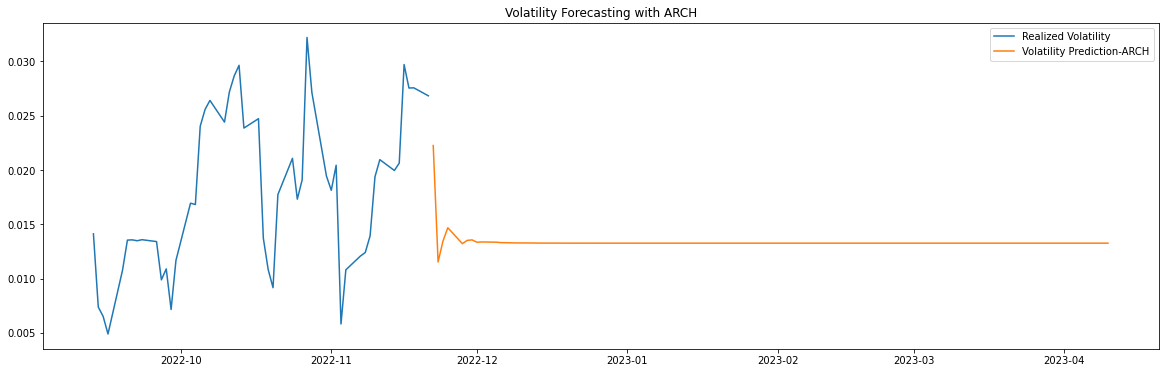

In [31]:
n_forecast = 100
_ = classic_forecast(df=df, horizon=n_forecast, model=arch, plotres=True)

As we can see, since the next value is predicted based on the previous (which is also predicted unless it is our latest day) and ignorant of any real-world events, it will very likely to converge. This obviously does not reflect the behaviour of the real market. At all!

As a result, the practical usage (which is also the principal usage) of volatility prediction is **one-step ahead**, where our model's output is **one** value that reflect the market's **current** tendency to fluctuate in the near future.

**CURRENT**.

PLEASE REMEMBER, **CURRENT**.

#### II. Generalized ARCH (GARCH) - Bollerslev, 1986 and Taylor, 1986

**What is it**:
GARCH is an extension of ARCH by incorporating an autoregressive moving average model (ARMA) for the conditional variance ($\sigms$)

**Form of GARCH - Equation 2**:
> $\sigma_{t}^{2}=\omega+\sum^{q}_{k=1}\alpha_{k}(r_{t-k})^2+\sum^{p}_{k=1}\beta_{k}(\sigma^{2}_{t-k})$

The following conditions should be satisfied (so that GARCH can fit consistently):
- $\omega>0$
- $\alpha>0$
- $\beta>0$
- $\alpha + \beta < 1$

**Some properties of GARCH**:
1. GARCH takes historical volatility into consideration. We can mathematically prove that GARCH can be written as an infinite order of ARCH.
2. 


**Training and Inference using GARCH**

We don't need to build the model from scratch since there is already a library for it. We determine the best-performing hyperparameters $p$ and $q$ in Equation 2.

In [32]:
def GARCH_modelSelect(ret):
    bic_garch = []
    best_params = -1, -1
    for p in range(1, 5):
        for q in range(1, 5):
            garch = arch_model(ret,
                               mean='zero',
                               vol='GARCH',
                               p=p, o=0, q=q).fit(disp='off')
            bic_garch.append(garch.bic)
            if garch.bic == np.min(bic_garch):
                best_params = p, q
    return best_params, arch_model(ret,
                                   mean='zero',
                                   vol='GARCH',
                                   p=best_params[0], o=0, q=best_params[1]).fit(disp='off')

best_hyperparams, garch = GARCH_modelSelect(ret=df['return'])
print(garch.summary())
print(f"The best p and q are respectively {best_hyperparams[0]} and {best_hyperparams[1]}")

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3430.61
Distribution:                  Normal   AIC:                           6867.21
Method:            Maximum Likelihood   BIC:                           6884.55
                                        No. Observations:                 2390
Date:                Fri, Feb 10 2023   Df Residuals:                     2390
Time:                        13:21:28   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0281  1.200e-02      2.344  1.907e-02 [4.

Testing and calculating RMSE:

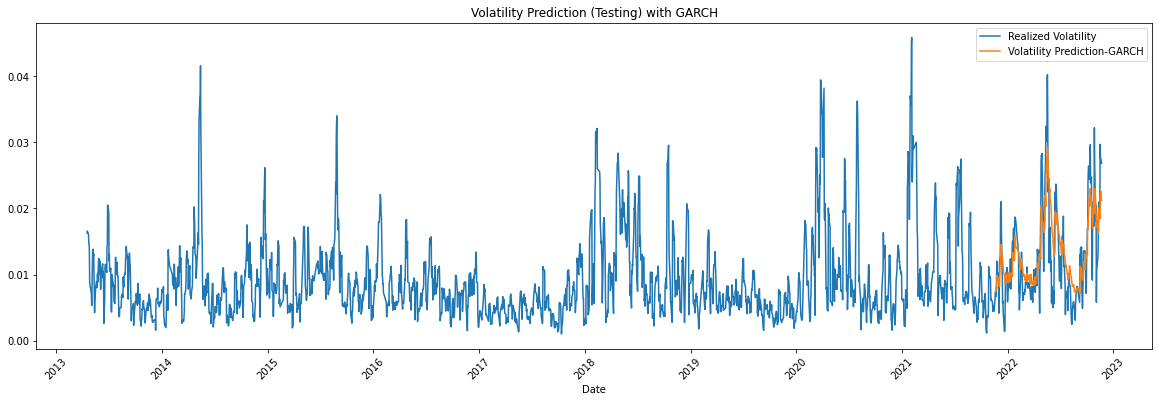

The RMSE value of GARCH model is 0.0141


In [33]:
test_garch = garch.forecast(start=test_start-1)
plt.figure(figsize=(20, 6))

# Build predicted dataframe
pred_date = df['date'][test_start:]
pred_vola = test_garch.variance['h.1'].values[test_start-1:-1]
pred_dict = {
    'date': pred_date,
    'vola': pred_vola
}
pred = pd.DataFrame(pred_dict)

# Plot
plt.plot(df['date'], df['realized_vol']/100, label='Realized Volatility')
plt.plot(pred['date'], np.sqrt(pred['vola']) / 100, label='Volatility Prediction-GARCH', alpha=1)
# plt.plot(df['date'], np.sqrt(test_arch.variance) / 100, label='Volatility Prediction-ARCH', alpha=1)
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Volatility Prediction (Testing) with GARCH', fontsize=12)
plt.legend()
plt.show()

rmse_garch = np.sqrt(mse(test_label / 100,
                        np.sqrt(pred.vola) / 100))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))

#### III. Support Vector Regression GARCH (SVR-GARCH)

**What is it**:
In machine learning, support vector machines (SVMs, also support vector networks) are supervised learning models with associated learning algorithms that analyze data for classification and regression analysis.

The goal of SVM is to identify a boundary (in its simplest form, this boundary is a hyperplane) between two classes. Among what could be countless of lines that may be used to separate the classes, one reasonable choice as the best hyperplane is the one that represents the largest margin between the two classes.

SVM, with all of its characteristics can be applied to regression.  Such models are called SVR. Similar to SVM, the goal of SVR is to identify the hyperplane that maximizes margin and minimizes error.

In case the data we work on cannot be linearly separable, we will need *Kernel Functions*. Their general purpose is to project the data into another space (e.g., generating new features to put aside or replace the original features) where we can separate the classes with a hyperplane.

**Common kernel functions**:
1. Polynomial kernel
> $K(x,z)=(x^{T}z+b)^{d}$

2. Gaussian kernel
> $K(x,z)=\mathrm{exp}\left(-\frac{|x-z|^{2}}{2\sigma^{2}}\right)$

3. Exponential kernel
> $K(x,z)=\mathrm{exp}\left(-\frac{|x-z|}{\sigma} \right)$

**Training and Inference using SVR-GARCH**

We will be training and testing SVR-GARCH on 3 kernels: linear, polynomial, Gaussian.

First, we need our build our dataset. Our predictor is be the square of historical return $x$ and our forecast variable is unchanged, the **realized volatility** $y$ of the next day.

Now let's declare our SVRs with different kernels

In [34]:
svr_poly = SVR(kernel='poly', degree=2)
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

svr = {
    'poly': svr_poly,
    'lin': svr_lin,
    'rbf': svr_rbf
}

svr_namelookup = {
    'poly': 'Polynomial',
    'lin': 'Linear',
    'rbf': 'RBF'
}

**Here are some useful functions**:

In [35]:
# Function for model selection
def SVR_modelSelect(kernel: str):
    para_grid = {'gamma': sp_rand(),
                 'C': sp_rand(),
                 'epsilon': sp_rand()}
    return RandomizedSearchCV(svr[kernel], para_grid)

In [36]:
class SVRservice:
    
    def __init__(self, data_dict, data_in, kernel: str, pretrained_model=None, test_scheme=1):
        self.test_scheme = test_scheme
        self.data_dict = data_dict
        data = None
        if test_scheme == 1:
            data = data_in.dropna().reset_index(drop=True)
            self.date = data['date']
        elif test_scheme == 2:
            train_keys = list(data_dict.keys())
            train_keys.remove('VNINDEX')
            train_keys.remove('VN30INDEX')
            self.date = data_dict[train_keys[0]]
            datalist = []
            new_data_dict = data_dict
            for stock in data_dict:
                df = data_dict[stock][['return', 'realized_vol', 'future_rv']]
                datalist.append(df)
            data = pd.concat(datalist, axis=0, ignore_index=True).dropna().sample(frac=1).reset_index(drop=True)
        else:
            print('Please only pass 1 or 2 to the test_scheme argument')
            return

        self.label = data['future_rv']
        self.realized_vol = data['realized_vol']
        square_ret = self.realized_vol ** 2
        self.X = pd.concat([square_ret, self.realized_vol], axis=1, ignore_index=True).reset_index(drop=True)
        self.kernel = kernel
        if pretrained_model:
            self.model = pretrained_model
        else:
            self.model = SVR_modelSelect(kernel=kernel)
        self.num_test = None
        
    def train(self, num_test):
        
        assert num_test < len(self.X), 'num_test cannot be larger than data length'
        
        # Change service num_test for testing later
        self.num_test = num_test
        test_start = len(self.date) - num_test
        
        # Training data
        x_train = self.X[:test_start]
        y_train = self.label[:test_start]
        
        # Select and train model
        self.model.fit(x_train, y_train)
        
    def test(self, test_series: str, printres=False, plotres=False, prev=0):
        
        # Data
        if self.test_scheme == 1:
            assert prev + self.num_test <= len(self.X), 'please choose a smaller prev'
            test_start = len(self.date) - self.num_test
            x_test = self.X[test_start:]
            y_test = self.label[test_start:]
            pred_date = self.date[test_start:]
            
        elif self.test_scheme == 2:
            test_df = self.data_dict[test_series][['date', 'return', 'realized_vol', 'future_rv']] \
                            .dropna() \
                            .reset_index(drop=True)
            pred_date = test_df['date']
            x_test = pd.concat([test_df['return']**2, test_df['realized_vol']], axis=1, ignore_index=True)
            y_test = test_df = test_df['future_rv']
        
        testlen = len(x_test)
        
        # Predict on test set and calculate RMSE
        pred_svr = self.model.predict(x_test)
        rmse_svr = np.sqrt(mse(y_test / 100, pred_svr / 100))
        
        if printres:
            print('The RMSE value of SVR with {} Kernel is {:.4f}' .format(svr_namelookup[self.kernel], rmse_svr))
            
        # Predicted DataFrame
        pred_dict = {
            'date': pred_date,
            'vola': pred_svr
        }
        pred = pd.DataFrame(pred_dict)
        
        if plotres:
            plt.figure(figsize=(20, 6))
            if self.test_scheme == 1:
                plt.plot(self.date[-(prev+testlen):], self.realized_vol[-(prev+testlen):] / 100,
                         label='Realized Volatility')
                plt.plot(pred['date'], pred['vola'] / 100,
                         label='Volatility Prediction-SVR-GARCH', alpha=0.75)
            if self.test_scheme == 2:
                plt.plot(pred_date[-100:], y_test[-100:] / 100,
                         label='Realized Volatility')
                plt.plot(pred['date'][-100:], pred['vola'][-100:] / 100,
                         label='Volatility Prediction-SVR-GARCH', alpha=0.75)
            plt.title(f'Volatility Prediction with SVR-GARCH ({svr_namelookup[self.kernel]})', fontsize=12)
            plt.legend()
            plt.show()
            
        return pred_svr, rmse_svr

Starting services:

In [37]:
SVR_service_lin = SVRservice(None, df, 'lin')
SVR_service_poly = SVRservice(None, df, 'poly')
SVR_service_rbf = SVRservice(None, df, 'rbf')

Starting training:

In [38]:
SVR_service_lin.train(251)
SVR_service_poly.train(251)
SVR_service_rbf.train(251)

Starting testing:

The RMSE value of SVR with Linear Kernel is 0.0037


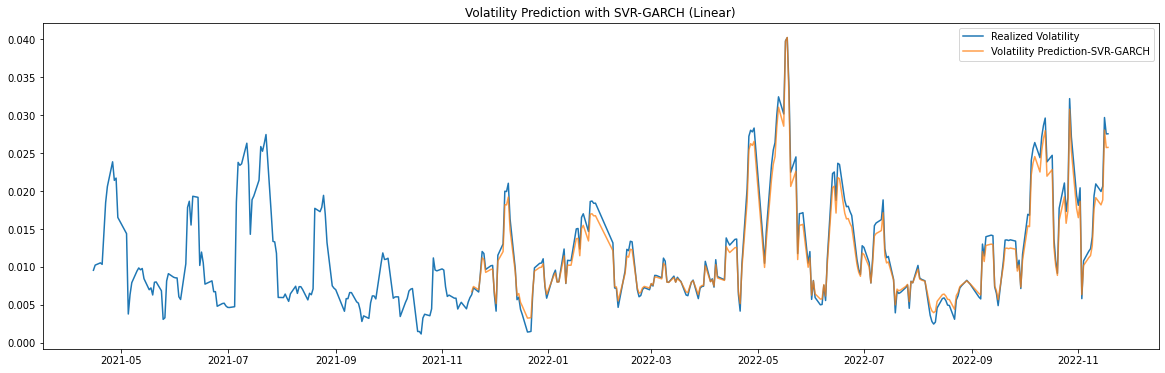

In [39]:
_,_ = SVR_service_lin.test('', printres=True, plotres=True, prev=150)

The RMSE value of SVR with Polynomial Kernel is 0.0037


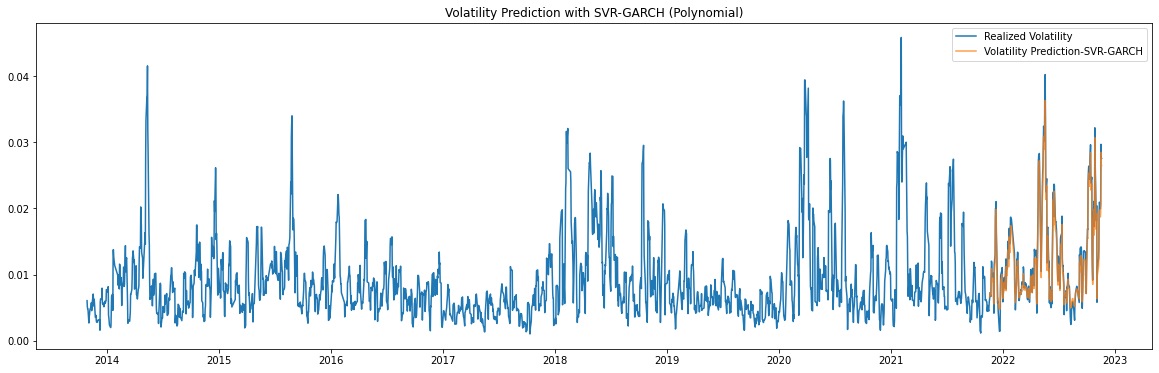

In [40]:
_,_ = SVR_service_poly.test('', printres=True, plotres=True, prev=2000)

The RMSE value of SVR with RBF Kernel is 0.0037


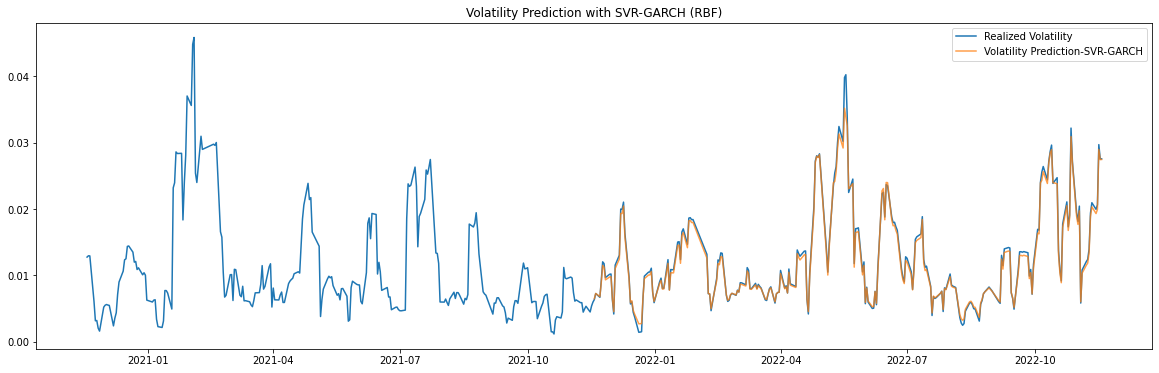

In [41]:
_,_ = SVR_service_rbf.test('', printres=True, plotres=True, prev=250)

#### III. Neural Networks

**What are they?**

You know about this. Let's dive right in. Let's do some useful functions:

In [42]:
# Function for model selection
def MLP_modelSelect(learning_rate=0.001):
    NN_vol = MLPRegressor(learning_rate_init=learning_rate, random_state=1)
    para_grid_NN = {
        'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
        'max_iter': [500, 1000],
        'alpha': [0.00005, 0.0005]}
    return RandomizedSearchCV(NN_vol, para_grid_NN)

In [43]:
class MLPservice:
    
    def __init__(self, data_dict, data_in, learning_rate=0.001, pretrained_model=None, test_scheme=1):
        self.test_scheme = test_scheme
        self.data_dict = data_dict
        data = None
        if test_scheme == 1:
            data = data_in.dropna().reset_index(drop=True)
            self.date = data['date']
        elif test_scheme == 2:
            train_keys = list(data_dict.keys())
            train_keys.remove('VNINDEX')
            train_keys.remove('VN30INDEX')
            self.date = data_dict[train_keys[0]]
            datalist = []
            new_data_dict = data_dict
            for stock in data_dict:
                df = data_dict[stock][['return', 'realized_vol', 'future_rv']]
                datalist.append(df)
            data = pd.concat(datalist, axis=0, ignore_index=True).dropna().sample(frac=1).reset_index(drop=True)
        else:
            print('Please only pass 1 or 2 to the test_scheme argument')
            return
        
        self.label = data['future_rv']
        self.realized_vol = data['realized_vol']
        square_ret = self.realized_vol ** 2
        self.X = pd.concat([square_ret, self.realized_vol], axis=1, ignore_index=True).reset_index(drop=True)
        self.lr = learning_rate
        if pretrained_model:
            self.model = pretrained_model
        else:
            self.model = MLP_modelSelect(learning_rate)
        self.num_test = None
        
    def train(self, num_test):
        
        assert num_test < len(self.X), 'num_test cannot be larger than data length'
        
        # Change service num_test for testing later
        self.num_test = num_test
        test_start = len(self.date) - num_test
        
        # Training data
        x_train = self.X[:test_start]
        y_train = self.label[:test_start]
        
        # Select and train model
        self.model.fit(x_train, y_train)
    
    def test(self, test_series, printres=False, plotres=False, prev=0):
        # Data
        if self.test_scheme == 1:
            assert prev + self.num_test <= len(self.X), 'please choose a smaller prev'
            test_start = len(self.date) - self.num_test
            x_test = self.X[test_start:]
            y_test = self.label[test_start:]
            pred_date = self.date[test_start:]
            
        elif self.test_scheme == 2:
            test_df = self.data_dict[test_series][['date', 'return', 'realized_vol', 'future_rv']] \
                            .dropna() \
                            .reset_index(drop=True)
            pred_date = test_df['date']
            x_test = pd.concat([test_df['return']**2, test_df['realized_vol']], axis=1, ignore_index=True) \
                            .reset_index(drop=True)
            y_test = test_df = test_df['future_rv']
            
        testlen = len(x_test)
        
        # Predict on test set and calculate RMSE
        pred_mlp = self.model.predict(x_test)
        rmse_mlp = np.sqrt(mse(y_test / 100, pred_mlp / 100))
        
        if printres:
            print('The RMSE value of MLP is {:.4f}' .format(rmse_mlp))
            
        # Predicted DataFrame
        pred_dict = {
            'date': pred_date,
            'vola': pred_mlp
        }
        pred = pd.DataFrame(pred_dict)
        
        if plotres:
            plt.figure(figsize=(20, 6))
            if self.test_scheme == 1:
                plt.plot(self.date[-(prev+testlen):], self.realized_vol[-(prev+testlen):] / 100,
                         label='Realized Volatility')
                plt.plot(pred['date'], pred['vola'] / 100, label='Volatility Prediction-MLP', alpha=0.75)
            if self.test_scheme == 2:
                plt.plot(pred_date[-100:], y_test[-100:] / 100,
                         label='Realized Volatility')
                plt.plot(pred['date'][-100:], pred['vola'][-100:] / 100, label='Volatility Prediction-MLP', alpha=0.75)
            plt.title(f'Volatility Prediction with MLP', fontsize=12)
            plt.legend()
            plt.show()
            
        return pred_mlp, rmse_mlp

In [44]:
MLP_service_0001 = MLPservice(None, df)
MLP_service_0001.train(251)

The RMSE value of MLP is 0.0036


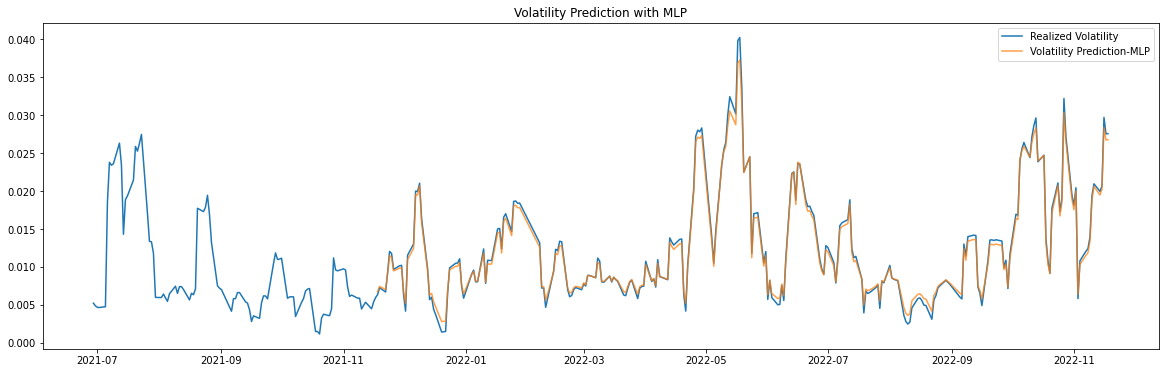

In [45]:
_,_ = MLP_service_0001.test(251, printres=True, plotres=True, prev=100)

***The Modern Prophecy (trial)***:

The forecast function:

In [46]:
def forecast(df: pd.DataFrame, model):
    # Forecast
    return model.predict([[df['return'].iloc[-1]**2, df['realized_vol'].iloc[-1]]])

Let's try forecasting with MLP and Linear SVR

In [47]:
print(forecast(df, MLP_service_0001.model))
print(forecast(df, SVR_service_lin.model))

[1.28855958]
[2.03456194]


### The Second Method of Evaluating

To further evaluate our suggested models (SVR and MLP), we will train them on data from 30 stocks of VN30 and test them on an unseen time series (for example, the VN-INDEX)

Training:

In [63]:
# SVR_service_lin_2 = SVRservice(data_dict=data_dict, data_in=None, kernel='lin', test_scheme=2)
MLP_service_2 = MLPservice(data_dict=data_dict, data_in=None, test_scheme=2)
# SVR_service_lin_2.train(0)
MLP_service_2.train(0)

Testing:

The RMSE value of SVR with Linear Kernel is 0.0052


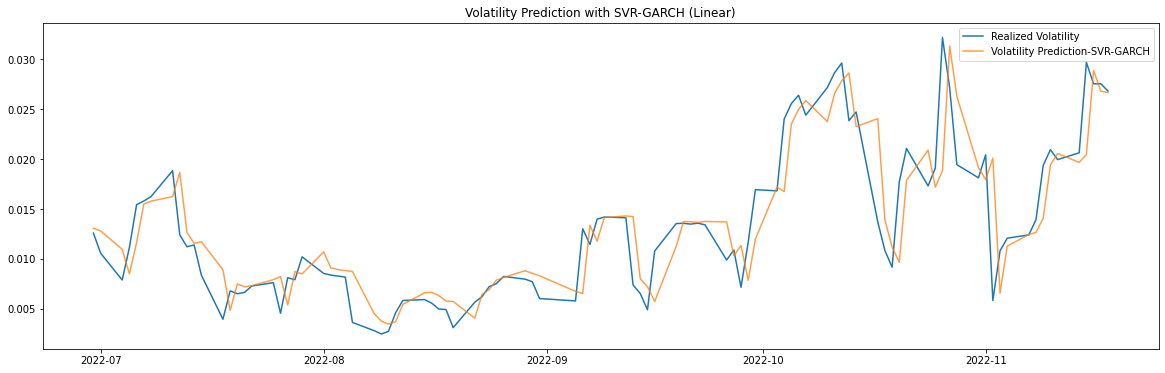

In [59]:
_,_ = SVR_service_lin_2.test('VNINDEX', printres=True, plotres=True)

The RMSE value of MLP is 0.0147


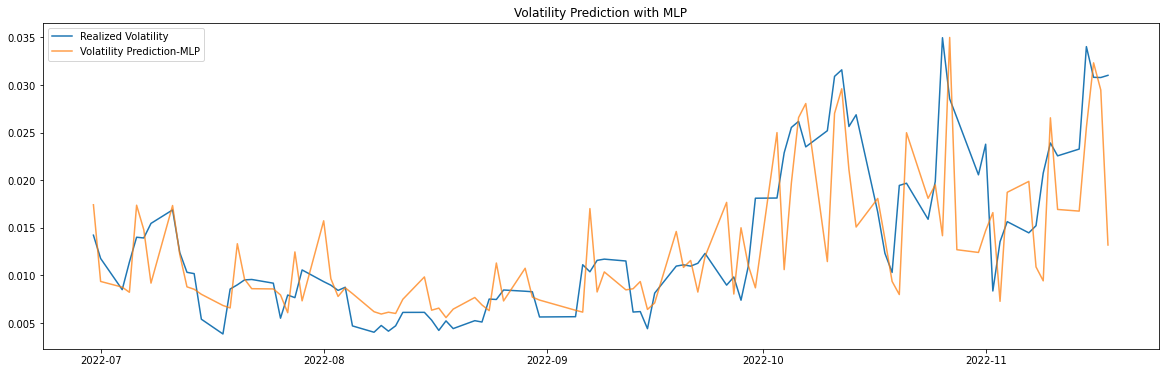

In [64]:
_,_ = MLP_service_2.test('VN30INDEX', printres=True, plotres=True)

The RMSE value of SVR with Linear Kernel is 0.0057


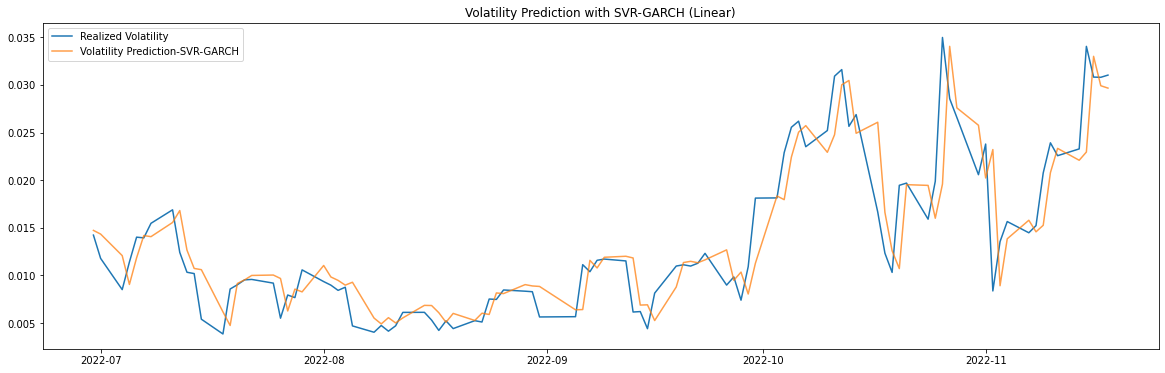

In [61]:
_,_ = SVR_service_lin_2.test('VN30INDEX', printres=True, plotres=True)

The RMSE value of MLP is 0.0114


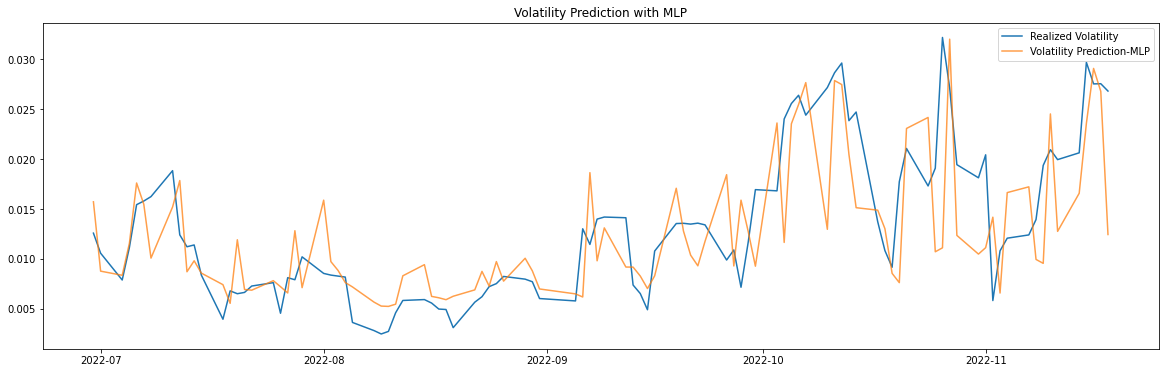

In [65]:
_,_ = MLP_service_2.test('VNINDEX', printres=True, plotres=True)